## *In silico* mutagenesis

In an *in silico* mutagenesis experiment, we have some input sequence $S$ of length $L$ which we would like to mutate.
In the simplest case of *in silico* mutagenesis, we make predict the effects of each individual $3L$ SNPs that are possible in $S$.
The *in silico* mutagenesis tools in Selene allow us to do this easily, and can also be used to predict the effects of every pair/triplet/etc of SNPs in our input sequence.

In [1]:
import os

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

import selene_sdk.interpret
from selene_sdk.interpret import ISMResult
from selene_sdk.sequences import Genome

Get all the logit files that were created running _in silico_ mutagenesis (ISM) in Selene, and load them as ISMResult objects. This data structure allows us to easily access the logit scores for the feature in our model as a matrix.

In [2]:
input_dir = "ism_outputs"
all_results = []
for filename in os.listdir(input_dir):
    all_results.append((
        filename.split('.')[0],
        ISMResult.from_file(os.path.join(input_dir, filename))))

This is a modification of the `visualize` method we provided in our tutorial. We have adapted it here for our specific use case: visualizing multiple heatmaps (ISM logit scores for different sequences) for a single feature in the model. 

In [3]:
def visualize(filename, ism_result, start=400, end=600, output_dir='.'):
    feature = "Proery_BM|GATA1"

    scores_mat = ism_result.get_score_matrix_for(feature)[start:end,]
    reference_encoding = Genome.sequence_to_encoding(
        ism_result.reference_sequence)[start:end,] == 1.
    figure, (ax) = plt.subplots(1, 1, figsize=(24, 4))
    ax.patch.set(edgecolor="gray", hatch="//")
    
    coordinates = filename.split('_')[:-1]
    chrom, cstart, cend = coordinates
    center = int((int(cend) - int(cstart)) / 2)
    
    ax.set_title(
        "Center 200 bp of 1000 bp sequence ({0}, {1}, {2})".format(
            chrom, center + int(cstart) - 500, center + int(cstart) + 500),
        fontdict={"fontsize": 20})
    heatmap = selene_sdk.interpret.heatmap(
        scores_mat,
        mask=reference_encoding,
        cbar=True,
        cmap="bwr_r",
        vmin=-1 * max(np.max(scores_mat),
                      np.abs(np.min(scores_mat))),
        vmax=max(np.max(scores_mat), np.abs(np.min(scores_mat))),
        ax=ax,
        linewidth=0.5,
        xticklabels=list(range(start, end)),
        cbar_kws=dict(use_gridspec=False, location="bottom", pad=0.3))
    heatmap.set_xlabel("position in sequence", fontdict={"fontsize": 20})
    heatmap.set_ylabel("bases", fontdict={"fontsize": 20})
    
    # only show every other base position in the x-axis
    for label in heatmap.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    plt.savefig(os.path.join(output_dir, "{0}.png".format(filename)), dpi=300)

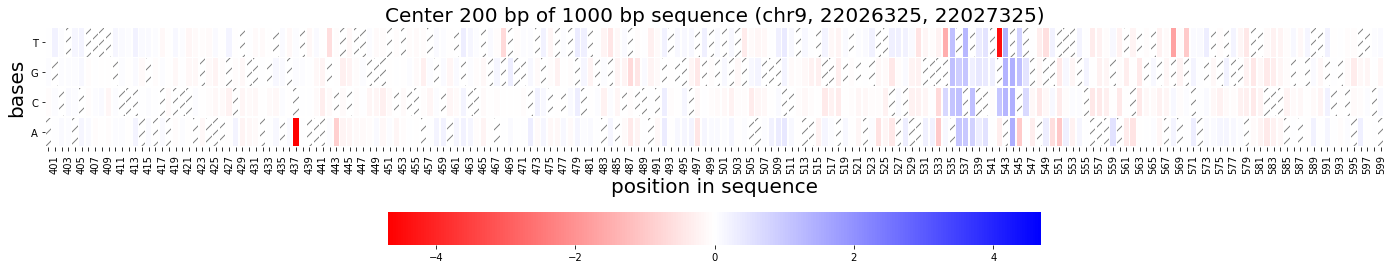

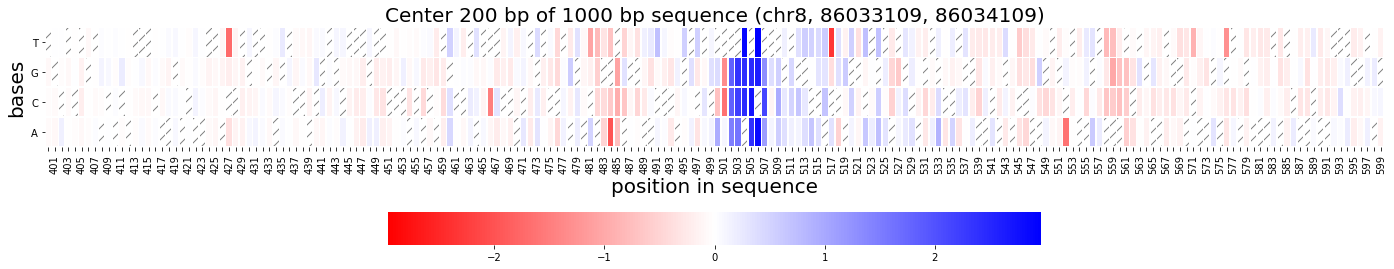

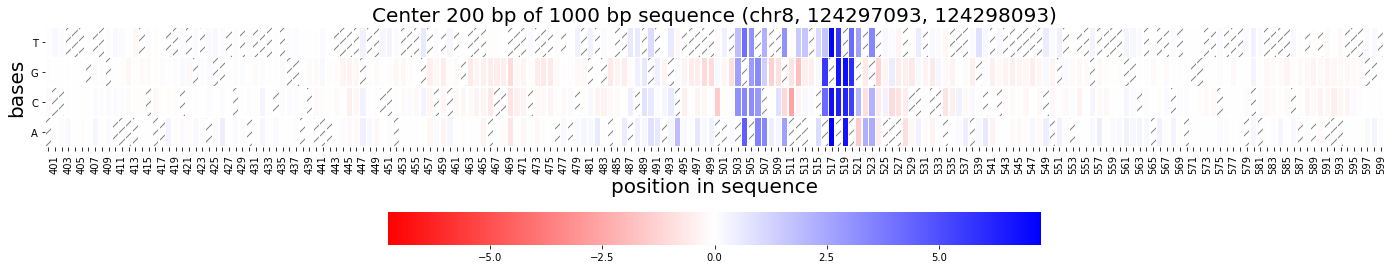

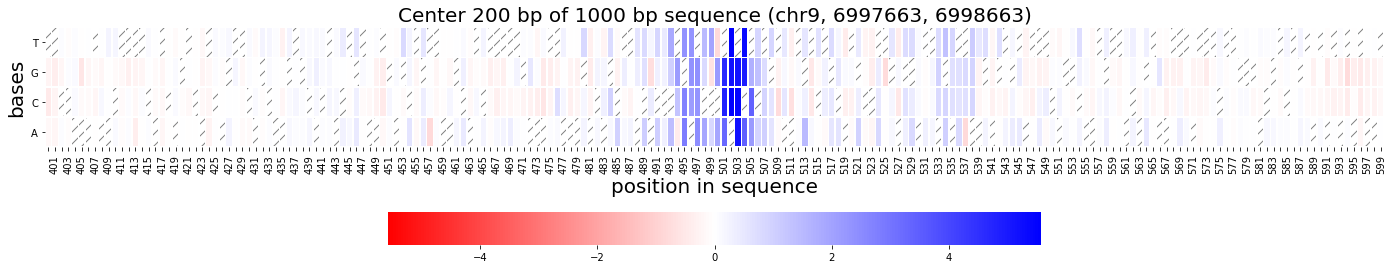

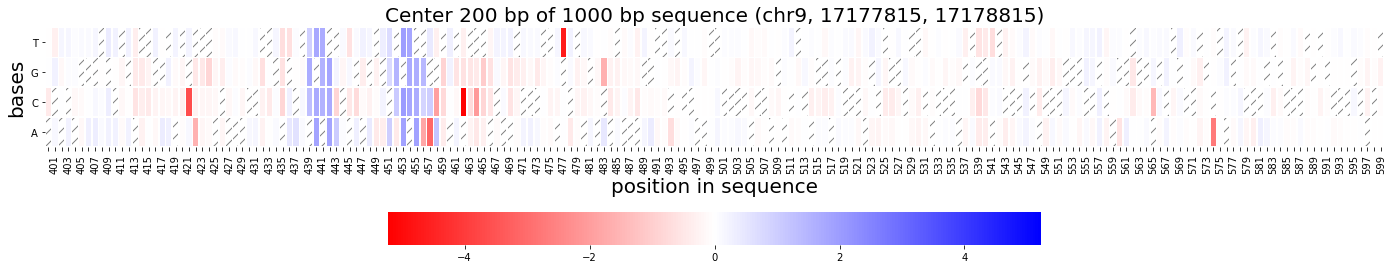

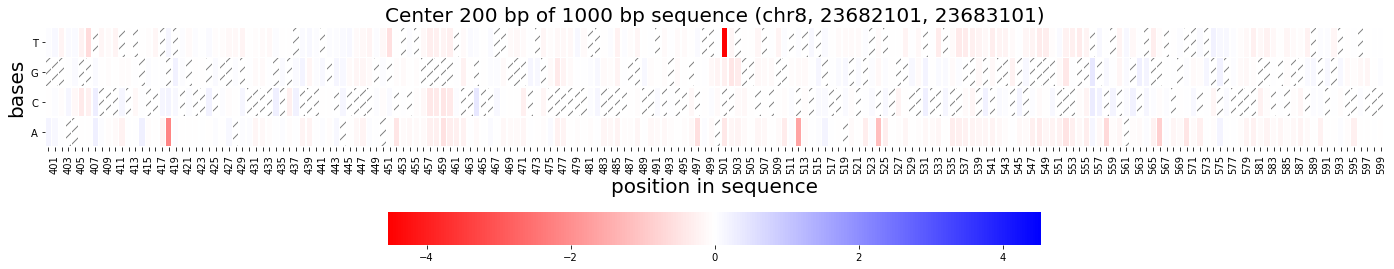

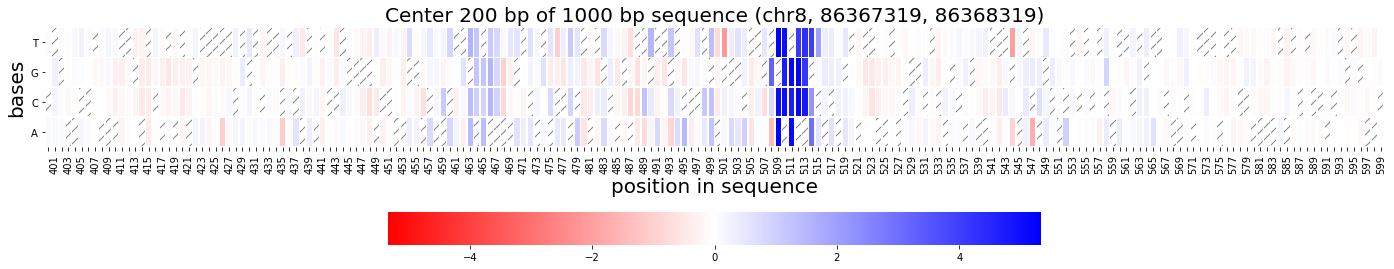

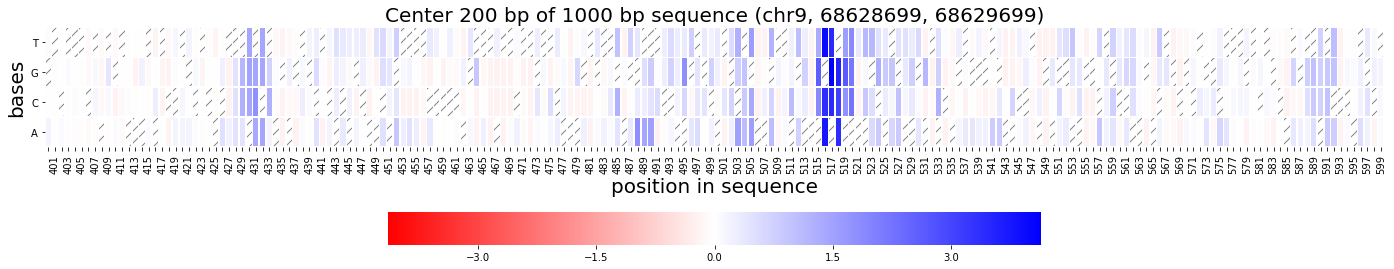

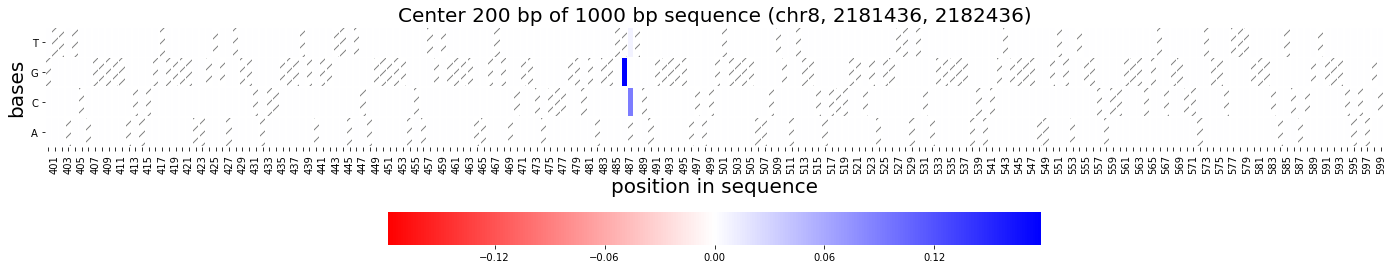

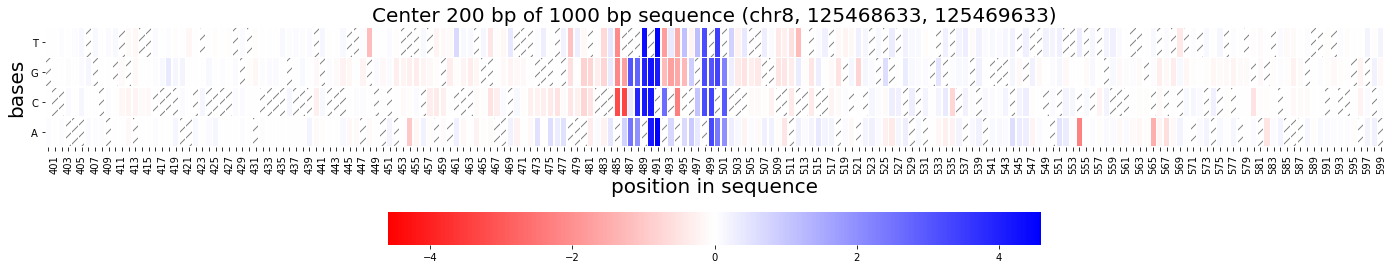

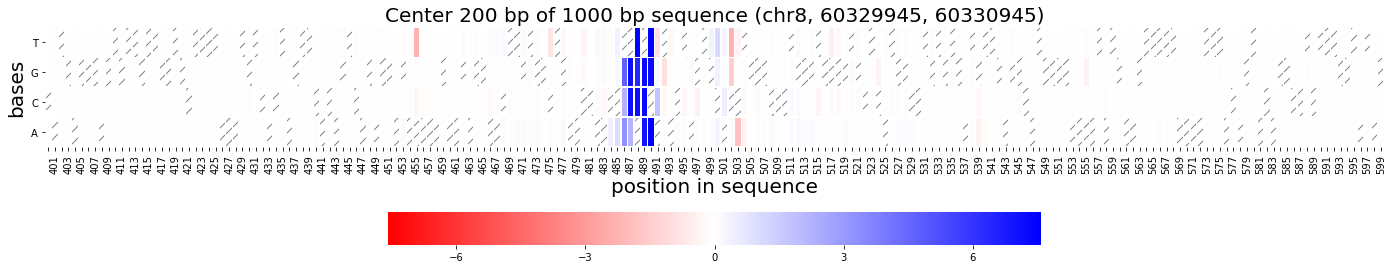

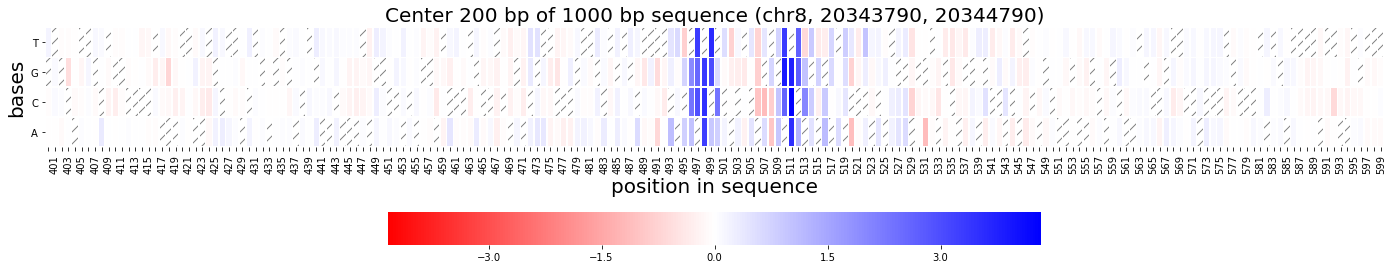

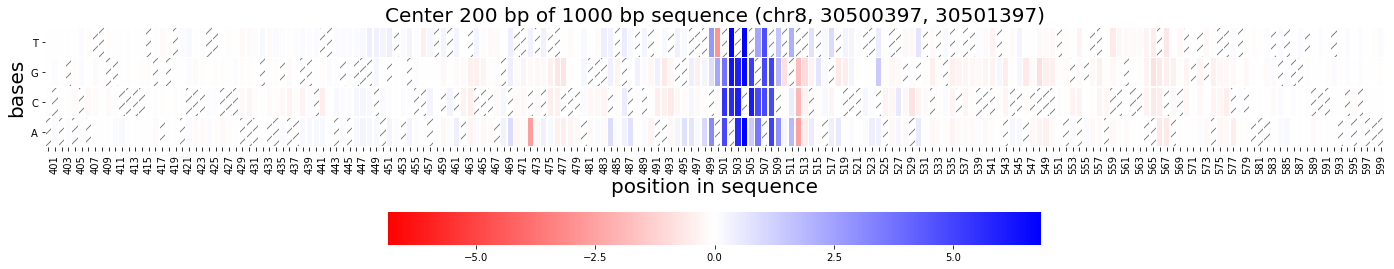

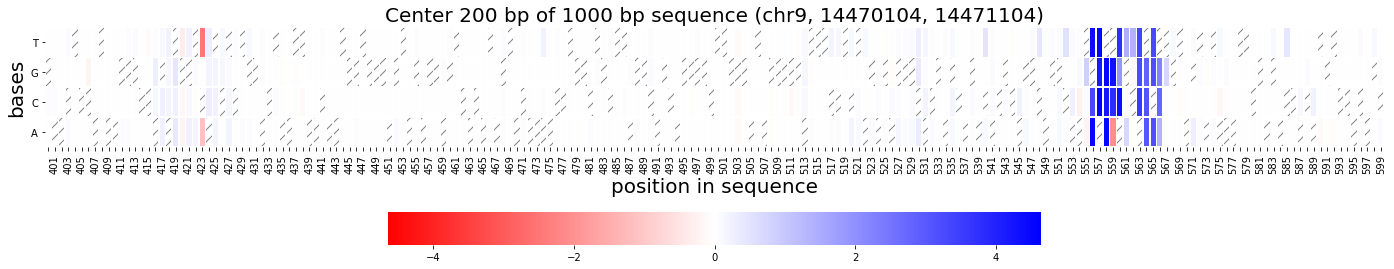

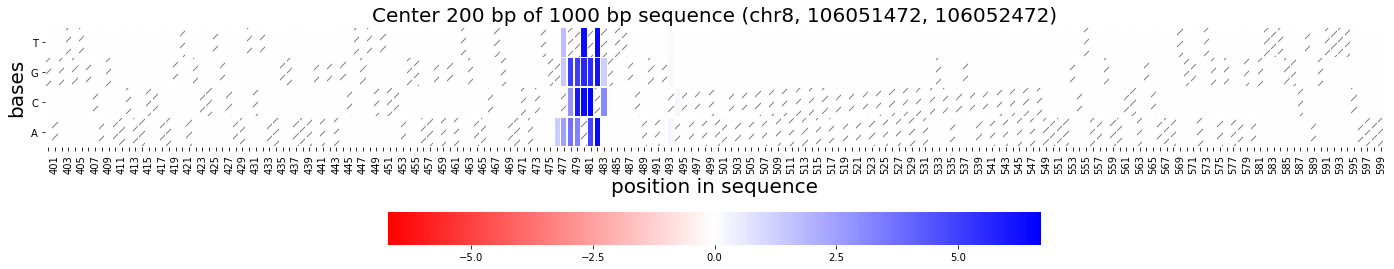

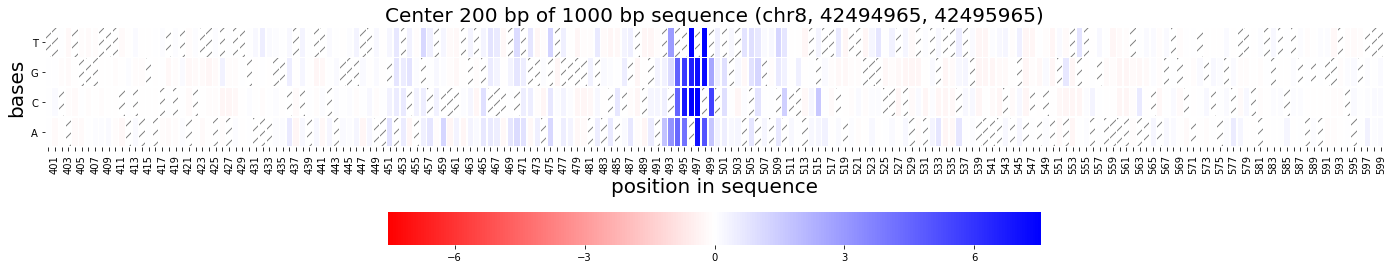

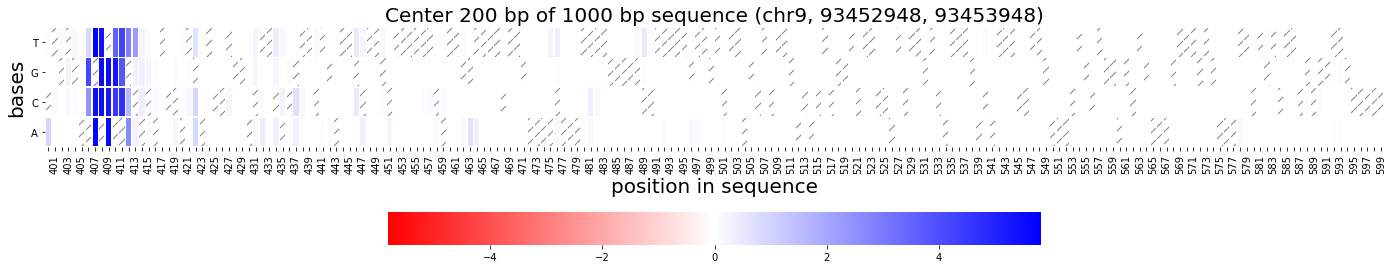

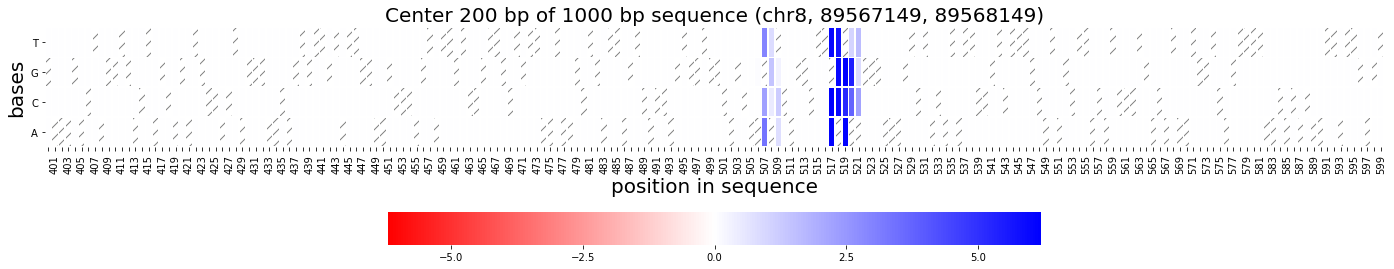

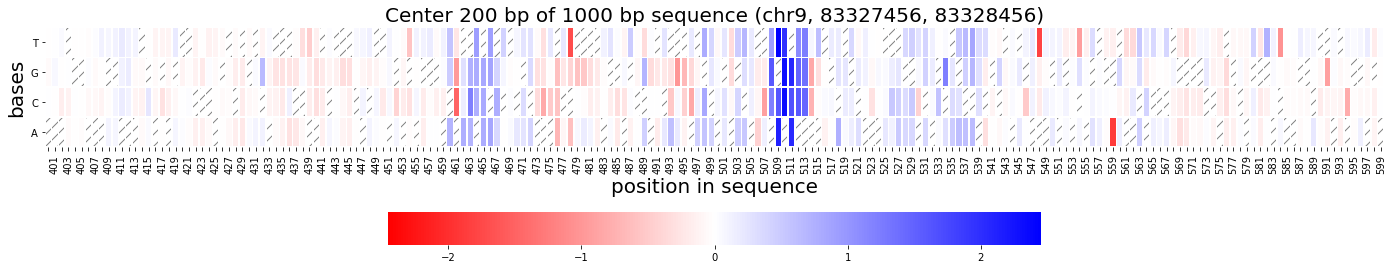

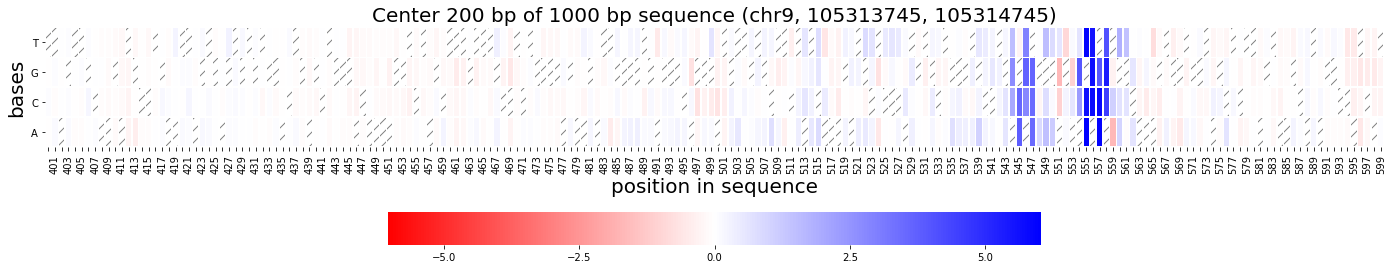

In [4]:
output_dir = "visualize_ism_outputs"
os.makedirs(output_dir, exist_ok=True)
for filename, result in all_results:
    visualize(filename, result, output_dir=output_dir)